## Importing Libraries

In [1]:
from fastai.vision import *
from fastai.callbacks import *

## Downloading Dataset and Setting up Paths

In [2]:
path = untar_data(URLs.CAMVID)
print(path)
path.ls()

C:\Users\RAJDEEP\.fastai\data\camvid


[WindowsPath('C:/Users/RAJDEEP/.fastai/data/camvid/codes.txt'),
 WindowsPath('C:/Users/RAJDEEP/.fastai/data/camvid/images'),
 WindowsPath('C:/Users/RAJDEEP/.fastai/data/camvid/labels'),
 WindowsPath('C:/Users/RAJDEEP/.fastai/data/camvid/valid.txt')]

In [3]:
imgs_path = path/'images'
masks_path = path/'labels'
valid_files_path = path/'valid.txt'
classes_path = path/'codes.txt'

## Exploring the Dataset

In [4]:
img_filenames = get_image_files(imgs_path)
masks_filenames = get_image_files(masks_path)
print(len(img_filenames))
print(len(masks_filenames))

701
701


In [5]:
img_filenames[:3]

[WindowsPath('C:/Users/RAJDEEP/.fastai/data/camvid/images/0001TP_006690.png'),
 WindowsPath('C:/Users/RAJDEEP/.fastai/data/camvid/images/0001TP_006720.png'),
 WindowsPath('C:/Users/RAJDEEP/.fastai/data/camvid/images/0001TP_006750.png')]

In [6]:
masks_filenames[:3]

[WindowsPath('C:/Users/RAJDEEP/.fastai/data/camvid/labels/0001TP_006690_P.png'),
 WindowsPath('C:/Users/RAJDEEP/.fastai/data/camvid/labels/0001TP_006720_P.png'),
 WindowsPath('C:/Users/RAJDEEP/.fastai/data/camvid/labels/0001TP_006750_P.png')]

**Opening an Image and its corresponding Mask**

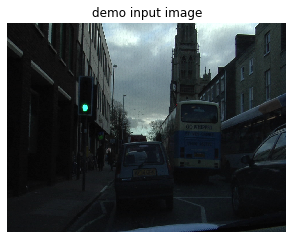

In [7]:
img_file = open_image(imgs_path/img_filenames[0])
img_file.show(figsize = (5,5), title = 'demo input image')

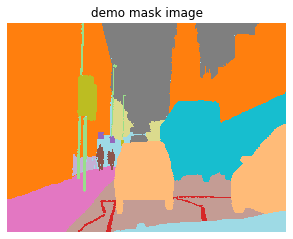

In [8]:
mask = open_mask(masks_path/masks_filenames[0], convert_mode = "L")
mask.show(figsize = (5,5), title = 'demo mask image', alpha = 1)

**Getting the Pixel Classes**

In [9]:
classes = np.loadtxt(classes_path, dtype = str)
print(len(classes))
print(classes)

32
['Animal' 'Archway' 'Bicyclist' 'Bridge' 'Building' 'Car' 'CartLuggagePram' 'Child' 'Column_Pole' 'Fence'
 'LaneMkgsDriv' 'LaneMkgsNonDriv' 'Misc_Text' 'MotorcycleScooter' 'OtherMoving' 'ParkingBlock' 'Pedestrian' 'Road'
 'RoadShoulder' 'Sidewalk' 'SignSymbol' 'Sky' 'SUVPickupTruck' 'TrafficCone' 'TrafficLight' 'Train' 'Tree' 'Truck_Bus'
 'Tunnel' 'VegetationMisc' 'Void' 'Wall']


# Training with Half the Input Image size

**Function to map Input Image to Mask**

In [10]:
get_label_mask_file = lambda x : masks_path/f'{x.stem}_P{x.suffix}'

**Creating the Databunch**

In [11]:
src = (SegmentationItemList.from_folder(imgs_path)
                           .split_by_fname_file(valid_files_path)
                           .label_from_func(get_label_mask_file, classes = classes))

In [12]:
# Halving the Input Image Size
input_img_size = np.array(img_file.shape[1:]) // 2   

batch_size = 4
data = (src.transform(get_transforms(), size = input_img_size, tfm_y = True)
           .databunch(bs = batch_size, num_workers = 0)
           .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: C:\Users\RAJDEEP\.fastai\data\camvid\images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: C:\Users\RAJDEEP\.fastai\data\camvid\images;

Test: None

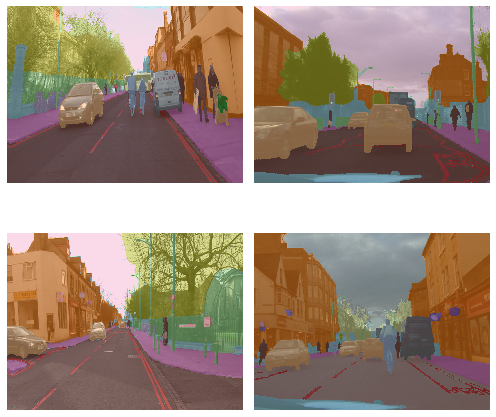

In [13]:
data.show_batch(2, figsize = (7,7))

**Creating the Learner**

In [14]:
name_to_index_map = {name:index for index, name in enumerate(classes)}
void_index = name_to_index_map['Void']

In [15]:
'''We define a Custom Accuracy metric since accuracy is to be measured without taking into account the pixels labelled as 'Void'
as those pixels are semantically ambiguous and hence not assigned a class while labelling the Dataset'''


def camvid_accuracy(output, target):
    target = target.squeeze(1)
    m = target != void_index
    mean_acc = (output.argmax(dim=1)[m] == target[m]).float().mean()
    return mean_acc

In [16]:
learn = unet_learner(data, models.resnet34, metrics = camvid_accuracy).to_fp16()

**Fitting the Learner**

In [17]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,camvid_accuracy,time
0,1.018790,0.845844,0.811286,01:52
1,0.833107,0.894773,0.798227,01:40
2,0.742537,0.725800,0.834665,01:43
3,0.634450,0.599609,0.854061,01:46
4,0.558202,0.444045,0.884431,01:45
5,0.494484,0.403177,0.885340,01:44
6,0.446625,0.360351,0.890284,01:43
7,0.403184,0.344682,0.896406,01:45
8,0.360321,0.328305,0.901117,01:46
9,0.345677,0.321633,0.905690,01:45


In [18]:
learn.save('half-size-stage-1')

**Finetuning the Learner**

epoch,train_loss,valid_loss,camvid_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


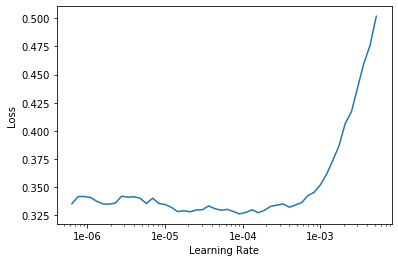

In [19]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [20]:
learning_rate = slice(1e-5,1e-4)
learn.fit_one_cycle(15, max_lr = learning_rate)

epoch,train_loss,valid_loss,camvid_accuracy,time
0,0.336738,0.322922,0.904993,01:50
1,0.335016,0.321319,0.906606,01:50
2,0.330453,0.308759,0.909729,01:49
3,0.331482,0.321979,0.906887,01:49
4,0.321420,0.310785,0.910853,01:47
5,0.318040,0.288020,0.919055,01:52
6,0.310179,0.306016,0.911572,01:49
7,0.300951,0.300133,0.913005,01:51
8,0.299873,0.292987,0.915918,01:52
9,0.289198,0.298191,0.914167,01:50


In [21]:
learn.save('half-size-stage-2')

## Training with the actual Input Image size

**Creating the Databunch**

In [22]:
input_img_size = np.array(img_file.shape[1:])

batch_size = 2
data = (src.transform(get_transforms(), size = input_img_size, tfm_y = True)
           .databunch(bs = batch_size, num_workers = 0)
           .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: C:\Users\RAJDEEP\.fastai\data\camvid\images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: C:\Users\RAJDEEP\.fastai\data\camvid\images;

Test: None

**Creating the Learner**

In [23]:
learn = unet_learner(data, models.resnet34, metrics = camvid_accuracy).to_fp16()
learn.load('half-size-stage-2');

In [24]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,camvid_accuracy,time
0,0.430117,0.377308,0.896610,05:16
1,0.491549,0.402916,0.901485,05:05
2,0.488169,0.382812,0.889790,05:08
3,0.449755,0.354718,0.903770,05:01
4,0.425483,0.364604,0.918273,05:00
5,0.394430,0.334288,0.912400,05:01
6,0.336063,0.339595,0.915368,05:00
7,0.320713,0.298590,0.924242,05:00
8,0.253194,0.265535,0.929393,05:03
9,0.256769,0.273044,0.927174,05:05


In [25]:
learn.save('full-size-stage-1')

**Finetuning the Learner**

epoch,train_loss,valid_loss,camvid_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


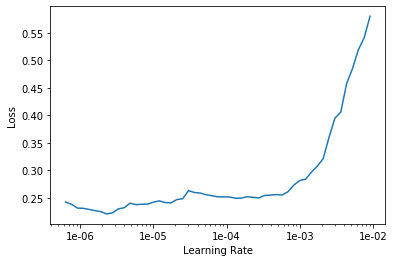

In [26]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [27]:
learning_rate = slice(1e-5,1e-4)
learn.fit_one_cycle(15, max_lr = learning_rate, callbacks = SaveModelCallback(learn, name = 'full-size-stage-2'))

epoch,train_loss,valid_loss,camvid_accuracy,time
0,0.266006,0.270762,0.927847,05:12
1,0.260890,0.268860,0.928505,05:13
2,0.269271,0.281881,0.925092,05:19
3,0.245212,0.272624,0.927617,05:29
4,0.238400,0.271372,0.928899,05:23
5,0.265739,0.274844,0.927779,05:31
6,0.234433,0.267876,0.930194,08:19
7,0.220567,0.273928,0.928302,09:19
8,0.239086,0.281668,0.926361,09:03
9,0.213058,0.280615,0.926158,08:17


Better model found at epoch 0 with valid_loss value: 0.2707620859146118.
Better model found at epoch 1 with valid_loss value: 0.26886019110679626.
Better model found at epoch 6 with valid_loss value: 0.26787593960762024.
Better model found at epoch 10 with valid_loss value: 0.2620495855808258.


## Checking Output Predictions

In [33]:
valid_loss_metrics = learn.validate()
print("Validation Loss: ", valid_loss_metrics[0])
print("Validation Accuracy: ", valid_loss_metrics[1].item() * 100)

Validation Loss:  0.2620496
Validation Accuracy:  93.12271475791931


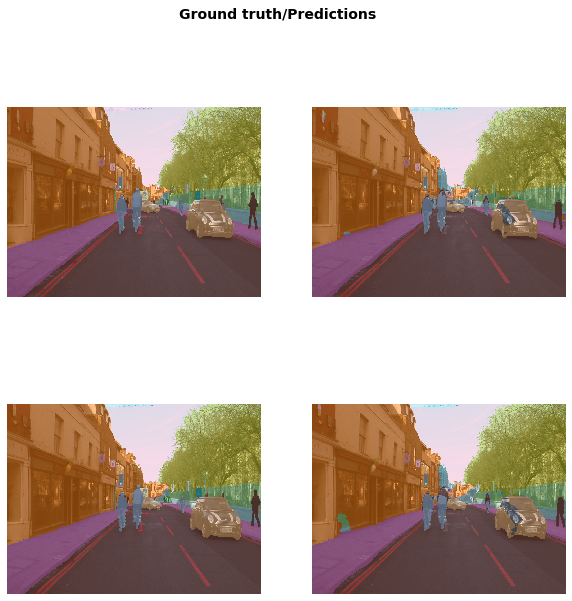

In [36]:
learn.show_results(rows=2, figsize=(10,10))

## Exporting the Trained Model

In [37]:
learn.export('final_trained_model.pkl')